In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import glob
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
import torch.utils.data as Data
from scipy.signal import savgol_filter as savgol
from datetime import datetime
import random

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/My Drive/data/'
people = list(filter(lambda x: "2019" in x and ("p0" in x or "p1" in x or "p2" in x), os.listdir(path)))

tasks = [
  'sustained_soft_70',
  'iterative_soft_70',
  'on-off_soft_70',
  'bending_soft_70',
  'sustained_strong_70',
  'iterative_strong_70',
  'on-off_strong_70',
  'bending_strong_70',
  'free_70'
]

batch_size = 100 # batch size, can be changed
num_train = 15
total_epoches = 15
loss_list = []
window_size = 50
hidden_size = 32

class RNN(nn.Module): 
    def __init__(self):
        super(RNN, self).__init__()    
        self.rnn = nn.LSTM(
            input_size=window_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
        )
        self.linear = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.out = nn.Tanh()
    def forward(self, x):
        x, _ = self.rnn(x, None)
        x = self.linear(x)
        x = self.relu(x)
        x = self.out(x)
        x = torch.mean(x, dim=1).view(x.shape[0], 1) 
        return x
model = RNN()
model.cuda()
print(model)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

RNN(
  (rnn): LSTM(50, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (out): Tanh()
)


In [ ]:
group = []
train_list = []

# random.shuffle(people)
random.shuffle(tasks)
print(people)
for name in people[:num_train]:
  for task in tasks:
    if len(group) < 5:
      group.append( (name,task) )
    else:
      train_list.append(group)
      group = [(name,task)]

for train_group in train_list:
  emg_data = []
  sound_rms = []
  for name_task in train_group:
    name = name_task[0]
    task = name_task[1]
    try:
      emg_r = np.load(os.path.join(path, name, task, 'emgr_raw.npy'))
      emg_l = np.load(os.path.join(path, name, task, 'emgl_raw.npy'))
      
      if emg_r.shape[1] > emg_l.shape[1]:
        emg_r = emg_r[ :, :emg_l.shape[1] ]
      else:
        emg_l = emg_l[ :, :emg_r.shape[1] ]

      emg = np.concatenate((emg_r, emg_l), axis=0)

      emg_data.append(emg)

      rms = np.load(os.path.join(path, name, task, 'sound_rms.npy'))

      if emg.shape[1] > rms.shape[0]:
        emg = emg[ :, :rms.shape[0] ]
      else:
        rms = rms[ :emg.shape[1] ]

      sound_rms.append(rms)
    except:
      pass

  for index in range(len(emg_data)):
    emg_temp = []
    for i in range(emg_data[index].shape[1]- window_size):
        emg_temp.append(emg_data[index][ : , i : i + window_size] )
    emg_temp = np.array(emg_temp)
    emg_temp = emg_temp[:int(emg_temp.shape[0] / batch_size) * batch_size,:,:]
    sound_rms[index] = sound_rms[index][:emg_temp.shape[0]]
    emg_data[index] = emg_temp
  

  emg_data = np.concatenate(emg_data, axis=0)
  sound_rms = np.concatenate(sound_rms, axis=0)
  print(emg_data.shape)
  print(sound_rms.shape)

  if emg_data.shape[0] > sound_rms.shape[0]:
    emg_data = emg_data[:sound_rms.shape[0], : , : ]
  else:
    sound_rms = sound_rms[ :emg_data.shape[0] ]

  print(emg_data.shape)
  print(sound_rms.shape)
  
  emg_data = torch.Tensor(emg_data)
  emg_data.cuda()
  sound_rms = torch.Tensor(sound_rms)
  sound_rms.cuda()

  dataset = Data.TensorDataset(emg_data, sound_rms)

  train_loader = Data.DataLoader(
      dataset=dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=4,
  )

  for epoch in range(total_epoches):
      total_loss = 0
      total_step = 1
      for step, (x, y) in enumerate(train_loader):
          batch_x = x.cuda()
          batch_y = y.cuda()
          out = model(batch_x)
          loss = criterion(out, batch_y)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          total_loss += loss
          total_step = step + 1
          if step % 1000 == 0:
              print("epoch {} step {} loss {}".format(epoch, step, total_loss/total_step ))
          loss_list.append(loss.item())

# torch.save(model.state_dict(), os.path.join(path, datetime.now().strftime("%Y%m%d-%H%M%S") + "_first_" + str(num_train) ) )

['p13_20191017', 'p15_20191017', 'p14_20191017', 'p05_20191007', 'p06_20191007', 'p12_20191009', 'p09_20191009', 'p04_20191007', 'p10_20191009', 'p01_20191008', 'p07_20191008', 'p08_20191008', 'p16_20191018', 'p25_20191101', 'p19_20191024', 'p20_20191024', 'p17_20191018', 'p18_20191024', 'p24_20191101', 'p21_20191025', 'p22_20191025', 'p03_20191111', 'p11_20191111', 'p27_20191108', 'p28_20191108', 'p26_20191108', 'p02_20191111']
(100900, 16, 50)
(100900,)
(100900, 16, 50)
(100900,)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


epoch 0 step 0 loss 0.3385075330734253
epoch 0 step 1000 loss 0.37988704442977905
epoch 1 step 0 loss 0.43881136178970337
epoch 1 step 1000 loss 0.3797619342803955
epoch 2 step 0 loss 0.4204871356487274
epoch 2 step 1000 loss 0.37954533100128174
epoch 3 step 0 loss 0.3749992251396179
epoch 3 step 1000 loss 0.3793226182460785
epoch 4 step 0 loss 0.30353766679763794
epoch 4 step 1000 loss 0.37974056601524353
epoch 5 step 0 loss 0.3424377739429474
epoch 5 step 1000 loss 0.37962907552719116
epoch 6 step 0 loss 0.3321986794471741
epoch 6 step 1000 loss 0.37947162985801697
epoch 7 step 0 loss 0.42661574482917786
epoch 7 step 1000 loss 0.37954002618789673
epoch 8 step 0 loss 0.40624305605888367
epoch 8 step 1000 loss 0.37960150837898254
epoch 9 step 0 loss 0.3054685592651367
epoch 9 step 1000 loss 0.37949925661087036
epoch 10 step 0 loss 0.3951404392719269
epoch 10 step 1000 loss 0.3797072172164917
epoch 11 step 0 loss 0.3942604064941406
epoch 11 step 1000 loss 0.37969252467155457
epoch 12 st

KeyboardInterrupt: ignored

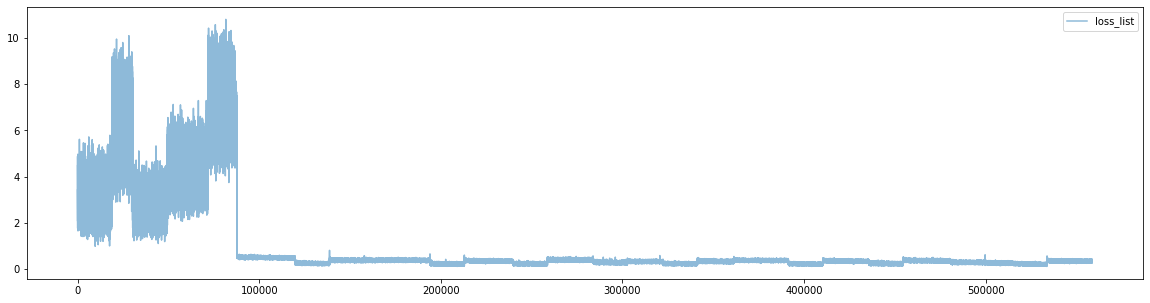

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(loss_list, label="loss_list", alpha=0.5)
plt.legend(loc="upper right")
# plt.xlim(20000, 120000)
# plt.ylim(0, 0.5)

In [ ]:
style

In [ ]:
model.load_state_dict(torch.load(path+"20191118-205027_first_15"))
style = plt.style.available
def raw_predict(people, task, title, figsize, style):
  print(people)
  testpath = os.path.join(path, people, task)
  test_r = np.load(testpath+'/emgr_raw.npy')
  test_l = np.load(testpath+'/emgl_raw.npy')

  if test_r.shape[1] > test_l.shape[1]:
    test_r = test_r[:, :test_l.shape[1]]
  else:
    test_l = test_l[:, :test_r.shape[1]]

  test = np.concatenate((test_r, test_l), axis=0)

  test = torch.Tensor(test).cuda()
  out = []
  for i in range(test.shape[1]-window_size):
    pred = model(test[:,i:i+window_size].unsqueeze(0))
    pred = pred.cpu().detach().numpy()
    out.append(pred)
    if i % 10000 == 0:
      print(i)
  out = np.array(out)
  test_rms = np.load(testpath+'/sound_rms.npy')
  plt.figure(figsize=figsize)
  plt.title(title, fontsize=16)
  plt.xlabel("Myo sensor sample", fontsize=16)
  plt.ylabel('RMS', fontsize=16)

  plt.plot(test_rms, label="Sound RMS", alpha=0.5)
  plt.plot(np.squeeze(out), label="Predicted RMS", alpha=0.4)
  plt.legend(loc="upper right", fontsize=16)
  # plt.xlim(10000, 20000)
  plt.style.use(style)
  plt.savefig( os.path.join(path, people, task+".pdf" ), bbox_inches='tight')
  return out, test_rms
def filter_predict(people, task, out, test_rms, title, figsize, style, xlim=None, ylim=None, window_size=5999):
  print(people)
  
  plt.figure(figsize=figsize)
  plt.plot(savgol(test_rms, window_size, 1), label="Sound RMS", alpha=0.5)
  pred = np.squeeze(out)
  plt.plot(savgol(pred, window_size, 1), label="Predicted RMS", alpha=0.4)

  plt.style.use(style)
  plt.title(title, fontsize=16)
  plt.xlabel("Myo sensor sample", fontsize=16)
  plt.ylabel('RMS', fontsize=16)
  plt.legend(loc="upper right", fontsize=16)
  if xlim != None:
    plt.xlim(xlim)
  if ylim != None:
    plt.ylim(ylim)
  plt.savefig( os.path.join(path, people, task+"_trend.pdf"), bbox_inches='tight' )

p17_20191018
0
10000
20000
30000
40000
50000
60000
p17_20191018


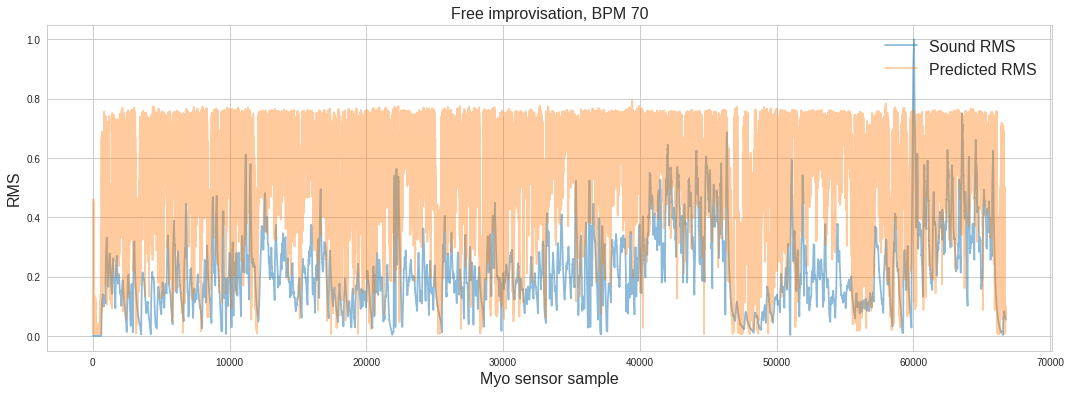

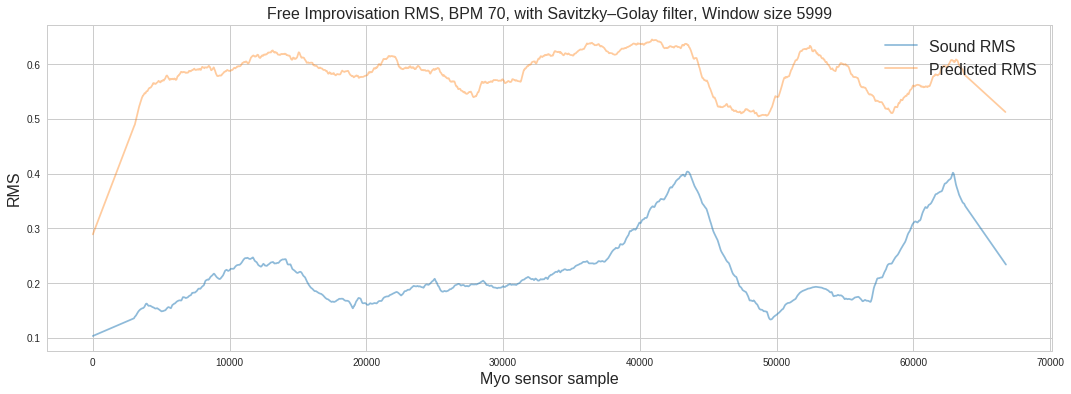

In [ ]:
out, test_rms = raw_predict(people=people[-5], task="free_70", title="Free improvisation, BPM 70", figsize=(18,6), style=style[8])
filter_predict(
    people[-5],
    "free_70",
    out,
    test_rms,
    "Free Improvisation RMS, BPM 70, with Savitzky–Golay filter, Window size 5999",
    figsize=(18,6),
    style=style[8])

p17_20191018
0
10000
20000
p17_20191018


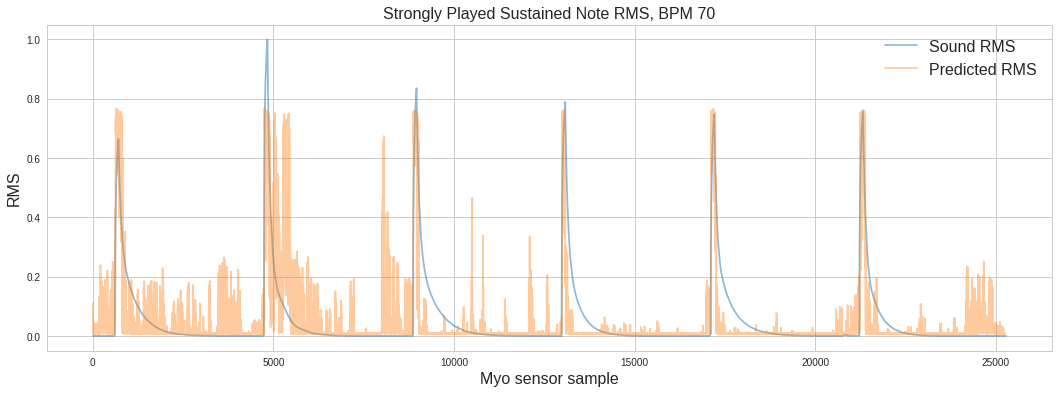

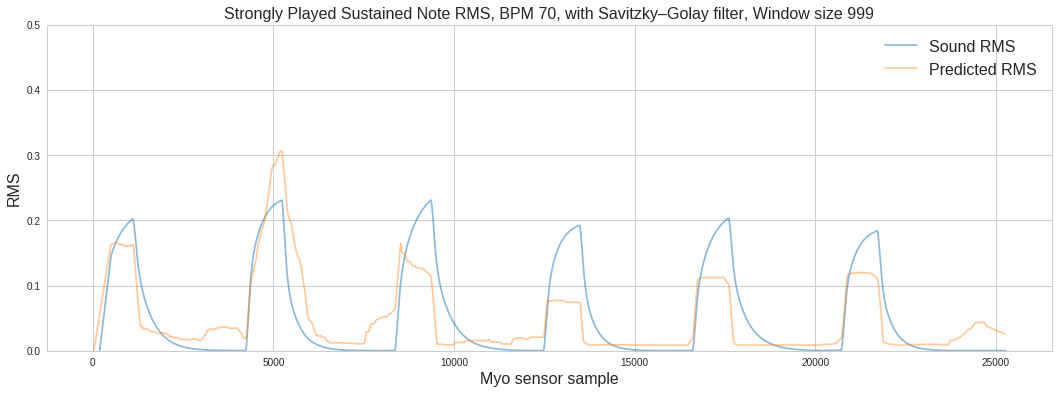

In [ ]:
out, test_rms = raw_predict(people=people[-5], task="sustained_strong_70", title="Strongly Played Sustained Note RMS, BPM 70", figsize=(18,6), style=style[7])
filter_predict(
    people[-5],
    "sustained_strong_70",
    out,
    test_rms,
    "Strongly Played Sustained Note RMS, BPM 70, with Savitzky–Golay filter, Window size 999",
    figsize=(18,6),
    style=style[7],
    # xlim=(2000, 10000),
    ylim=(0, 0.5),
    window_size=999)

p17_20191018
0
10000
20000
p17_20191018


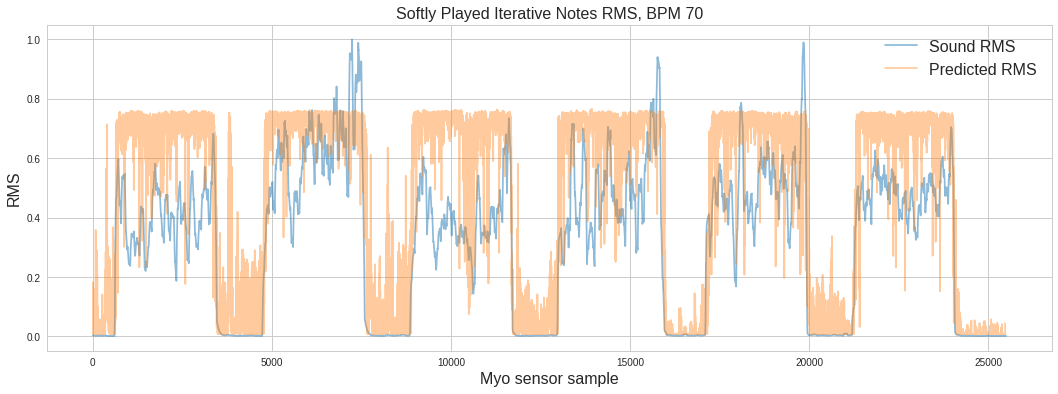

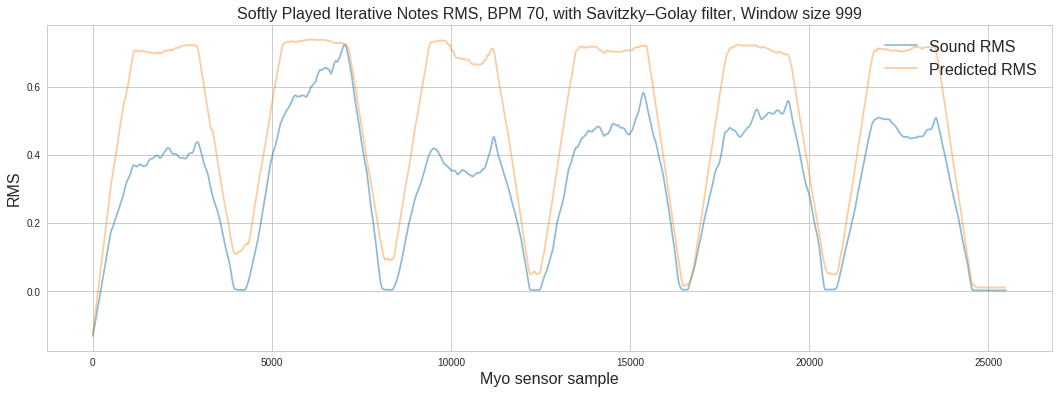

In [ ]:
out, test_rms = raw_predict(people=people[-5], task="iterative_soft_70", title="Softly Played Iterative Notes RMS, BPM 70", figsize=(18,6), style=style[7])
filter_predict(
    people[-5],
    "iterative_soft_70",
    out,
    test_rms,
    "Softly Played Iterative Notes RMS, BPM 70, with Savitzky–Golay filter, Window size 999",
    figsize=(18,6),
    style=style[7],
    # xlim=(2000, 10000),
    # ylim=(0, 0.5),
    window_size=999)

p17_20191018
0
10000
20000
p17_20191018


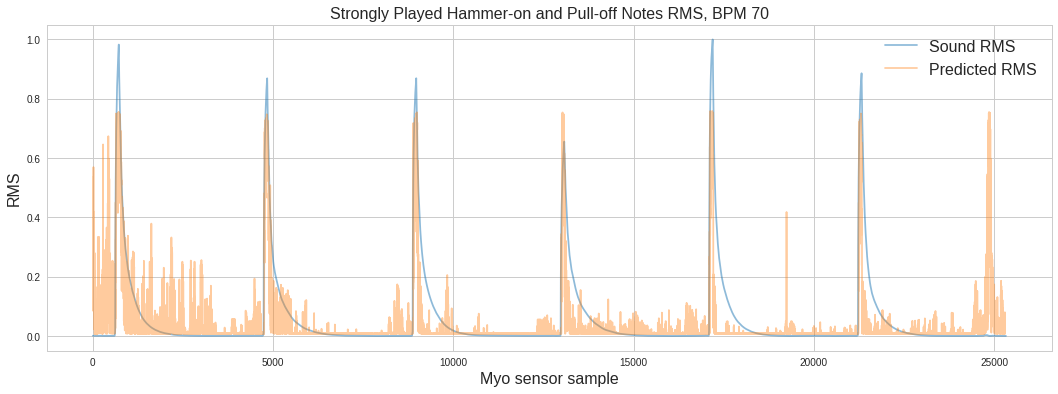

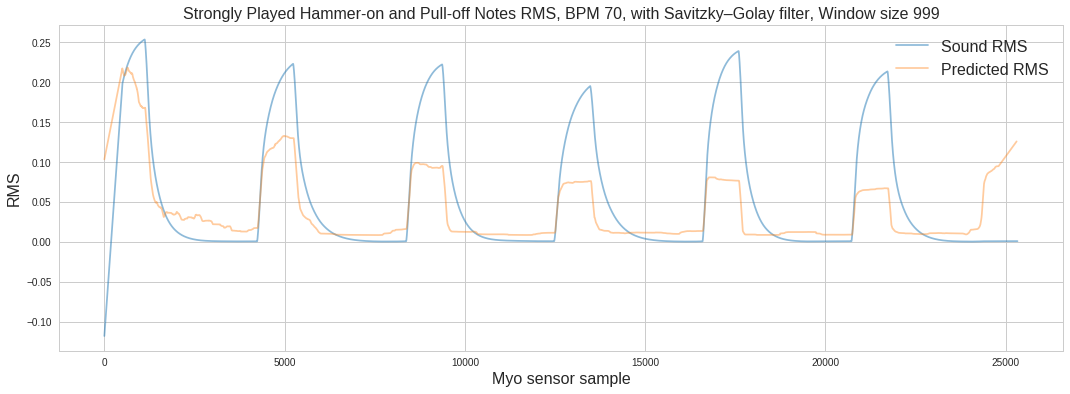

In [ ]:
out, test_rms = raw_predict(people=people[-5], task="on-off_strong_70", title="Strongly Played Hammer-on and Pull-off Notes RMS, BPM 70", figsize=(18,6), style=style[7])
filter_predict(
    people[-5],
    "on-off_strong_70",
    out,
    test_rms,
    "Strongly Played Hammer-on and Pull-off Notes RMS, BPM 70, with Savitzky–Golay filter, Window size 999",
    figsize=(18,6),
    style=style[7],
    # xlim=(2000, 10000),
    # ylim=(0, 0.5),
    window_size=999)

p17_20191018
0
10000
20000
p17_20191018


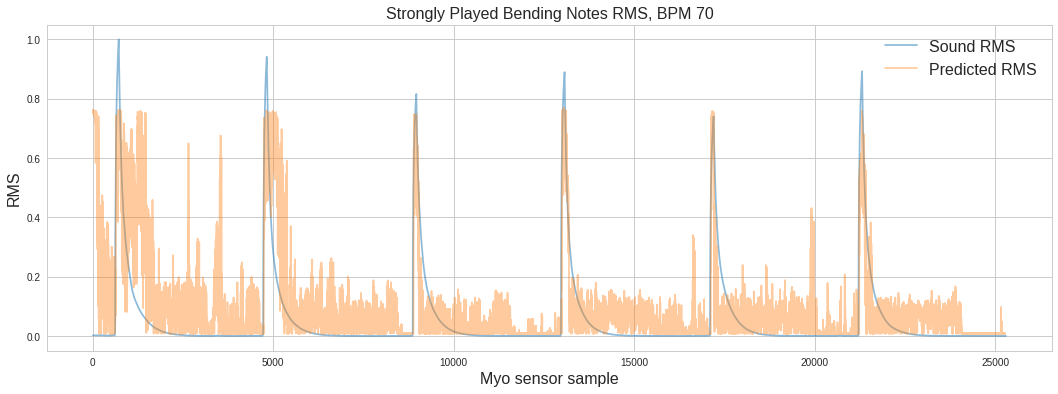

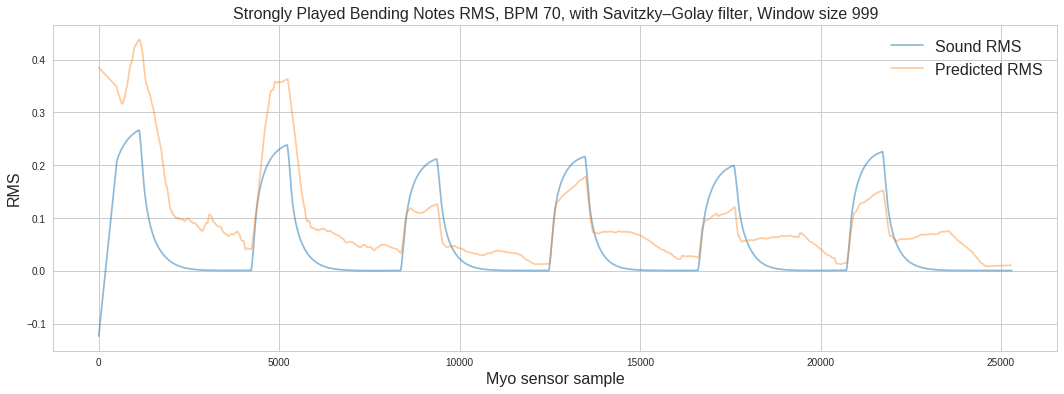

In [ ]:
out, test_rms = raw_predict(people=people[-5], task="bending_strong_70", title="Strongly Played Bending Notes RMS, BPM 70", figsize=(18,6), style=style[7])
filter_predict(
    people[-5],
    "bending_strong_70",
    out,
    test_rms,
    "Strongly Played Bending Notes RMS, BPM 70, with Savitzky–Golay filter, Window size 999",
    figsize=(18,6),
    style=style[7],
    # xlim=(2000, 10000),
    # ylim=(0, 0.5),
    window_size=999)